<a href="https://colab.research.google.com/github/cantaruttim/Rotinas/blob/main/Carteira.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q yfinance

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import yfinance as yf
from datetime import date
import sys

In [19]:
# 'B3SA3.SA', 'BBAS3.SA', 'BBDC3.SA', 'CMIG4.SA', 'GGBR4.SA', 'ITSA4.SA', 'PETR4.SA', 'TAEE11.SA',
acoes = ['VINO11.SA', 'VGIA11.SA', 'GALG11.SA', 'VGHF11.SA']
data_atual = date.today()

dataset = yf.download(acoes, start='2023-01-04',end=data_atual)['Close']
dataset

[*********************100%%**********************]  4 of 4 completed


,GALG11.SA,VGHF11.SA,VGIA11.SA,VINO11.SA
Date,,,,
2023-01-04,9.13,9.14,9.91,9.436
2023-01-05,9.18,9.10,9.95,9.342
2023-01-06,9.11,9.11,9.98,9.580
2023-01-09,9.11,9.15,9.97,9.468
2023-01-10,9.13,9.19,9.99,9.404
...,...,...,...,...
2023-10-09,9.27,9.53,9.50,8.370
2023-10-10,9.25,9.48,9.48,8.260
2023-10-11,9.25,9.50,9.52,8.310


In [20]:
dataset.to_csv('acoes.csv')

In [21]:
dataset

,GALG11.SA,VGHF11.SA,VGIA11.SA,VINO11.SA
Date,,,,
2023-01-04,9.13,9.14,9.91,9.436
2023-01-05,9.18,9.10,9.95,9.342
2023-01-06,9.11,9.11,9.98,9.580
2023-01-09,9.11,9.15,9.97,9.468
2023-01-10,9.13,9.19,9.99,9.404
...,...,...,...,...
2023-10-09,9.27,9.53,9.50,8.370
2023-10-10,9.25,9.48,9.48,8.260
2023-10-11,9.25,9.50,9.52,8.310


In [22]:
def alocacao_ativos(dataset, dinheiro_total, seed = 0, melhores_pesos = []):
  dataset = dataset.copy()

  if seed != 0:
    np.random.seed(seed)

  if len(melhores_pesos) > 0:
    pesos = melhores_pesos
  else:
    pesos = np.random.random(len(dataset.columns) - 1)
    pesos = pesos / pesos.sum()


  colunas = dataset.columns[1:]
  for i in colunas:
    dataset[i] = (dataset[i] / dataset[i][0])

  for i, acao in enumerate(dataset.columns[1:]):
    dataset[acao] = dataset[acao] * pesos[i] * dinheiro_total

  dataset['soma valor'] = dataset.sum(axis = 1)

  datas = dataset['Date']

  dataset.drop(labels = ['Date'], axis = 1, inplace = True)
  dataset['taxa retorno'] = 0.0

  for i in range(1, len(dataset)):
    dataset['taxa retorno'][i] = ((dataset['soma valor'][i] / dataset['soma valor'][i - 1]) - 1) * 100

  acoes_pesos = pd.DataFrame(data = {'Ações': colunas, 'Pesos': pesos * 100})

  return dataset, datas, acoes_pesos, dataset.loc[len(dataset) - 1]['soma valor']

In [23]:
dataset, datas, acoes_pesos, soma_valor = alocacao_ativos(pd.read_csv('acoes.csv'), 1000, 10);

<ipython-input-22-9a39134fcf29>:21: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



In [24]:
dataset

,GALG11.SA,VGHF11.SA,VGIA11.SA,VINO11.SA,soma valor,taxa retorno
0,354.707693,9.543212,291.396199,344.352897,1000.000000,0.000000
1,356.650240,9.501447,292.572368,340.922510,999.646565,-0.035343
2,353.930659,9.511887,293.454488,349.607966,1006.505001,0.686086
3,353.930659,9.553652,293.160467,345.520709,1002.165487,-0.431147
4,354.707693,9.595417,293.748537,343.185119,1001.236766,-0.092671
...,...,...,...,...,...,...
191,360.146817,9.950416,279.340457,305.450800,954.888489,-0.325574
192,359.369783,9.898210,278.752359,301.436524,949.456876,-0.568822
193,359.369783,9.919093,279.928556,303.261208,952.478639,0.318262
194,359.369783,9.950416,276.105999,304.356004,949.782201,-0.283097


In [25]:
def evolucao_acoes(dataset, datas):

  figura = px.line(title = "Evolução do Patrimônio")
  for i in dataset.drop(columns = ['soma valor', 'taxa retorno']).columns:
    figura.add_scatter(x = datas, y = dataset[i], name = i)
    figura.update_layout(hovermode="x")

  return figura.show()

evolucao_acoes(dataset, datas)

In [26]:
def evolucao_patrimonio_investido(dataset, datas):

  figura = px.line(x = datas,
                  y = dataset['soma valor'],
                  title = 'Evolução do Patrimônio')
  return figura.show()

evolucao_patrimonio_investido(dataset, datas)

## Sharpe Ratio

In [27]:
## média histórica da selic nos últimos
taxa_selic_historico  = np.array([13.65, 12.83, 4.98, 2.55, 5.68])

In [28]:
def alocacao_portfolio(dataset, dinheiro_total, sem_risco, repeticoes):
  dataset = dataset.copy()
  dataset_original = dataset.copy()

  lista_retorno_esperado = []
  lista_volatilidade_esperada = []
  lista_sharpe_ratio = []

  melhor_sharpe_ratio = 1 - sys.maxsize
  melhores_pesos = np.empty
  melhor_volatilidade = 0
  melhor_retorno = 0

  for _ in range(repeticoes):
    pesos = np.random.random(len(dataset.columns) - 1)
    pesos = pesos / pesos.sum()

    for i in dataset.columns[1:]:
      dataset[i] = dataset[i] / dataset[i][0]

    for i, acao in enumerate(dataset.columns[1:]):
      dataset[acao] = dataset[acao] * pesos[i] * dinheiro_total

    dataset.drop(labels = ['Date'], axis = 1, inplace=True)

    retorno_carteira = np.log(dataset / dataset.shift(1))
    matriz_covariancia = retorno_carteira.cov()

    dataset['soma valor'] = dataset.sum(axis = 1)
    dataset['taxa retorno'] = 0.0

    for i in range(1, len(dataset)):
      dataset['taxa retorno'][i] = np.log(dataset['soma valor'][i] / dataset['soma valor'][i - 1])

    #sharpe_ratio = (dataset['taxa retorno'].mean() - sem_risco) / dataset['taxa retorno'].std() * np.sqrt(246)
    retorno_esperado = np.sum(dataset['taxa retorno'].mean() * pesos) * 246
    volatilidade_esperada = np.sqrt(np.dot(pesos, np.dot(matriz_covariancia * 246, pesos)))
    sharpe_ratio = (retorno_esperado - sem_risco) / volatilidade_esperada

    if sharpe_ratio > melhor_sharpe_ratio:
      melhor_sharpe_ratio = sharpe_ratio
      melhores_pesos = pesos
      melhor_volatilidade = volatilidade_esperada
      melhor_retorno = retorno_esperado

    lista_retorno_esperado.append(retorno_esperado)
    lista_volatilidade_esperada.append(volatilidade_esperada)
    lista_sharpe_ratio.append(sharpe_ratio)

    dataset = dataset_original.copy()

  return melhor_sharpe_ratio, melhores_pesos, lista_retorno_esperado, lista_volatilidade_esperada, lista_sharpe_ratio, melhor_volatilidade, melhor_retorno

In [29]:
sharpe_ratio, melhores_pesos, ls_retorno, ls_volatilidade, ls_sharpe_ratio, melhor_volatilidade, melhor_retorno = alocacao_portfolio(pd.read_csv('acoes.csv'),
                                                                                                                                     250,
                                                                                                                                     taxa_selic_historico.mean() / 100,
                                                                                                                                     15000)

In [32]:
## 100, 5000 => 1.2454374630888962
## 250, 15000 => 1.223707391614204

sharpe_ratio

-0.39324408279758266

In [33]:
melhores_pesos

array([0.14495296, 0.83287261, 0.0166858 , 0.00548863])

In [34]:
_, _, acoes_pesos, soma_valor = alocacao_ativos(pd.read_csv('acoes.csv'), 250, melhores_pesos=melhores_pesos)

<ipython-input-22-9a39134fcf29>:21: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



In [35]:
acoes_pesos, soma_valor

(       Ações      Pesos
 0  GALG11.SA  14.495296
 1  VGHF11.SA  83.287261
 2  VGIA11.SA   1.668580
 3  VINO11.SA   0.548863,
 258.0761537124367)

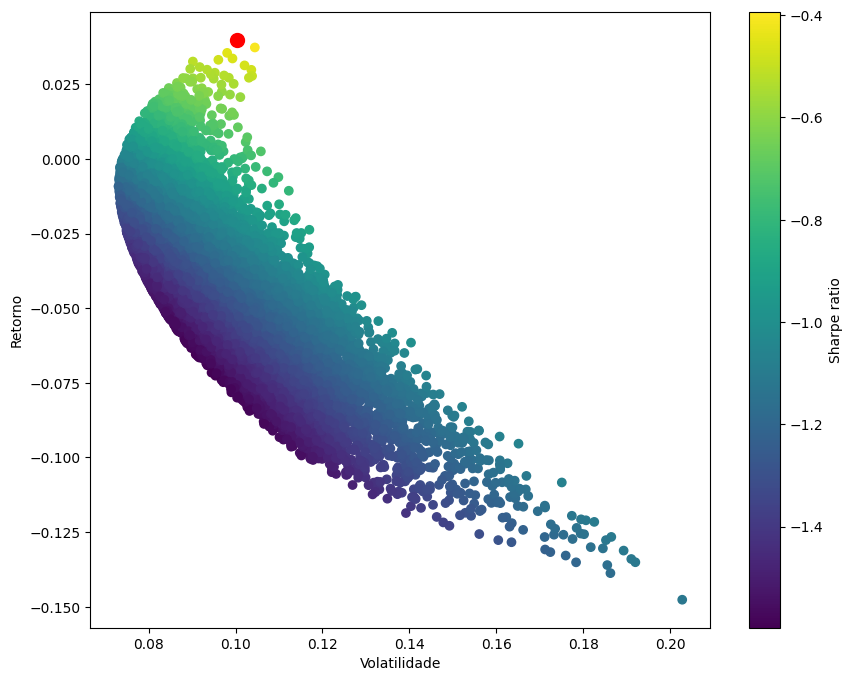

In [36]:
plt.figure(figsize=(10,8))
plt.scatter(ls_volatilidade, ls_retorno, c = ls_sharpe_ratio)
plt.colorbar(label = 'Sharpe ratio')
plt.xlabel('Volatilidade')
plt.ylabel('Retorno')
plt.scatter(melhor_volatilidade, melhor_retorno, c = 'red', s = 100);

## Otimização de portfólio com algoritmos de otimização

- Biblioteca mlrose: https://mlrose.readthedocs.io/en/stable/

In [ ]:
!pip install mlrose

  Using cached mlrose-1.3.0-py3-none-any.whl (27 kB)
  Using cached sklearn-0.0.post9.tar.gz (3.6 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for sklearn: filename=sklearn-0.0.post9-py3-none-any.whl size=2952 sha256=22e67150179948563a8f608a35d2053c273ec6974122b7a0ab617f9d37f4d077
  Stored in directory: /root/.cache/pip/wheels/33/a3/d2/092b519e9522b4c91608b7dcec0dd9051fa1bff4c45f4502d1
Successfully built sklearn


In [ ]:
!pip install scikit-learn==0.22

In [ ]:
import mlrose

In [ ]:
dataset_original = pd.read_csv('acoes.csv')
dinheiro_total = 5000
sem_risco = taxa_selic_historico.mean() / 100

In [ ]:
def fitness_function(solucao):
  dataset = dataset_original.copy()
  pesos = solucao / solucao.sum()

  for i in dataset.columns[1:]:
    dataset[i] = (dataset[i] / dataset[i][0])

  for i, acao in enumerate(dataset.columns[1:]):
    dataset[acao] = dataset[acao] * pesos[i] * dinheiro_total

  dataset.drop(labels = ['Date'], axis = 1, inplace=True)
  dataset['soma valor'] = dataset.sum(axis = 1)
  dataset['taxa retorno'] = 0.0

  for i in range(1, len(dataset)):
    dataset['taxa retorno'][i] = ((dataset['soma valor'][i] / dataset['soma valor'][i - 1]) - 1) * 100

  sharpe_ratio = (dataset['taxa retorno'].mean() - sem_risco) / dataset['taxa retorno'].std() * np.sqrt(246)

  return sharpe_ratio

In [ ]:
fitness_function(pesos)

In [ ]:
def visualiza_alocacao(solucao):
  colunas = dataset_original.columns[1:]
  for i in range(len(solucao)):
    print(colunas[i], solucao[i] * 100)

In [ ]:
visualiza_alocacao(pesos)

## Fundo de Investimentos

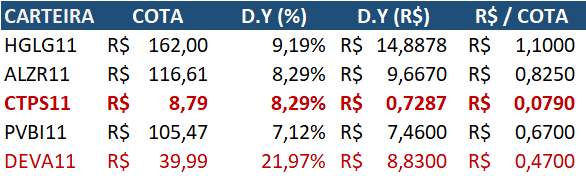

In [37]:
import pandas as pd
# "CARTEIRA": ['HGLG11', 'ALZR11', 'CTPS11', 'PVBI11', 'DEVA11', 'VINO11', 'VGIA11', 'GALG11', 'VGHF11']

FII = {"CARTEIRA": ['VINO11', 'VGIA11', 'GALG11', 'VGHF11'],
       "COTA": [9.52, 9.39, 9.25, 9.54],
       "D.Y %": [13.31, 19.17, 10.68, 13.31],
       "R$ / COTA":[0.0600, 0.1300, 0.0840, 0.1000]}
df = pd.DataFrame(FII)
df

,CARTEIRA,COTA,D.Y %,R$ / COTA
0,VINO11,9.52,13.31,0.060
1,VGIA11,9.39,19.17,0.130
2,GALG11,9.25,10.68,0.084
3,VGHF11,9.54,13.31,0.100


In [38]:
df['MAGIC NUMBER'] = (df['COTA'] / df['R$ / COTA'])
df['MAGIC NUMBER'] = round(df['MAGIC NUMBER'], 0)

## Alocação
df["INVESTIMENTO (MG)"] = df['COTA'] * df['MAGIC NUMBER']
df["INVESTIMENTO (MG)"] = round(df["INVESTIMENTO (MG)"], 2)

## QUAL O VALOR DO RETORNO AO ATINGIR O MG?
valor_investido = 250
df['# COTAS'] = (valor_investido / df['COTA'])
df['# COTAS'] = round(df['# COTAS'], 0)

## retorno mensal
df['RETORNO MENSAL'] = df['R$ / COTA'] * df['# COTAS']
df['RETORNO MENSAL'] = round(df['RETORNO MENSAL'], 2)

df

,CARTEIRA,COTA,D.Y %,R$ / COTA,MAGIC NUMBER,INVESTIMENTO (MG),# COTAS,RETORNO MENSAL
0,VINO11,9.52,13.31,0.060,159.0,1513.68,26.0,1.56
1,VGIA11,9.39,19.17,0.130,72.0,676.08,27.0,3.51
2,GALG11,9.25,10.68,0.084,110.0,1017.50,27.0,2.27
3,VGHF11,9.54,13.31,0.100,95.0,906.30,26.0,2.60


In [39]:
round(sum(df.iloc[:, 5].values), 2)

4113.56

In [40]:
taxa_media_de_juros = 4/100
taxa_media_de_juros

0.04

In [41]:
def periodo(meses):
  mesesLista = []
  for meses in range(1, meses + 1):
      mesesLista.append(f"MÊS {meses}")
  return mesesLista

meses = periodo(10)

In [ ]:
print(meses)

In [44]:
def seleciona_empresa(qtd_empresas):
  tickers = []
  analise = []

  for j in range(qtd_empresas):
      empresa = input(f"Ticker da empresa {j + 1}: ")
      tickers.append(empresa)

  for n in range(len(df['CARTEIRA'])):
      if df['CARTEIRA'][n] in tickers:
          analise.append(df.iloc[n])

  analise = pd.DataFrame(analise)

  return analise

lista_completa = seleciona_empresa(4)
lista_completa

Ticker da empresa 1: GALG11
Ticker da empresa 2: VINO11
Ticker da empresa 3: VGIA11
Ticker da empresa 4: VGHF11


,CARTEIRA,COTA,D.Y %,R$ / COTA,MAGIC NUMBER,INVESTIMENTO (MG),# COTAS,RETORNO MENSAL
0,VINO11,9.52,13.31,0.060,159.0,1513.68,26.0,1.56
1,VGIA11,9.39,19.17,0.130,72.0,676.08,27.0,3.51
2,GALG11,9.25,10.68,0.084,110.0,1017.50,27.0,2.27
3,VGHF11,9.54,13.31,0.100,95.0,906.30,26.0,2.60


In [45]:
lista_completa.iloc[:, -1]

0    1.56
1    3.51
2    2.27
3    2.60
Name: RETORNO MENSAL, dtype: float64

In [46]:
meses = int(input("Projeção para quantos meses: "))
taxa_media_de_juros = 4/100



def FIIS(meses, taxa_media_juros, retorno_inicial):

    resultados = [retorno_inicial]

    for j in range(meses + 1):
        resultados.append((resultados[j] * taxa_media_juros) + resultados[j])
    return resultados

resultados = FIIS(meses, taxa_media_de_juros,lista_completa.iloc[:, -1])
resultados

Projeção para quantos meses: 50


[0    1.56
 1    3.51
 2    2.27
 3    2.60
 Name: RETORNO MENSAL, dtype: float64,
 0    1.6224
 1    3.6504
 2    2.3608
 3    2.7040
 Name: RETORNO MENSAL, dtype: float64,
 0    1.687296
 1    3.796416
 2    2.455232
 3    2.812160
 Name: RETORNO MENSAL, dtype: float64,
 0    1.754788
 1    3.948273
 2    2.553441
 3    2.924646
 Name: RETORNO MENSAL, dtype: float64,
 0    1.824979
 1    4.106204
 2    2.655579
 3    3.041632
 Name: RETORNO MENSAL, dtype: float64,
 0    1.897979
 1    4.270452
 2    2.761802
 3    3.163298
 Name: RETORNO MENSAL, dtype: float64,
 0    1.973898
 1    4.441270
 2    2.872274
 3    3.289829
 Name: RETORNO MENSAL, dtype: float64,
 0    2.052854
 1    4.618921
 2    2.987165
 3    3.421423
 Name: RETORNO MENSAL, dtype: float64,
 0    2.134968
 1    4.803677
 2    3.106652
 3    3.558280
 Name: RETORNO MENSAL, dtype: float64,
 0    2.220366
 1    4.995824
 2    3.230918
 3    3.700611
 Name: RETORNO MENSAL, dtype: float64,
 0    2.309181
 1    5.195657
 2  

In [47]:
np.mean(df['MAGIC NUMBER'].values)

109.0

In [57]:
def seleciona_empresa(qtd_empresas):
  tickers = []
  analise = []

  for j in range(qtd_empresas):
      empresa = input(f"Ticker da empresa {j + 1}: ")
      tickers.append(empresa)

  for n in range(len(df['CARTEIRA'])):
      if df['CARTEIRA'][n] in tickers:
          analise.append(df.iloc[n])

  analise = pd.DataFrame(analise)

  return analise, tickers

lista_completa, tickers = seleciona_empresa(4)

meses = int(input("Projeção para quantos meses: "))
taxa_media_de_juros = 4/100


def FIIS(meses, empresas, taxa_media_juros, retorno_inicial):

    resultados = [retorno_inicial]

    for j in range(meses + 1):
        resultados.append((resultados[j] * taxa_media_juros) + resultados[j])
    return resultados

resultados = FIIS(meses, lista_completa, taxa_media_de_juros, lista_completa.iloc[:, -1])

Ticker da empresa 1: VGIA11
Ticker da empresa 2: VGHF11
Ticker da empresa 3: VINO11
Ticker da empresa 4: GALG11
Projeção para quantos meses: 50


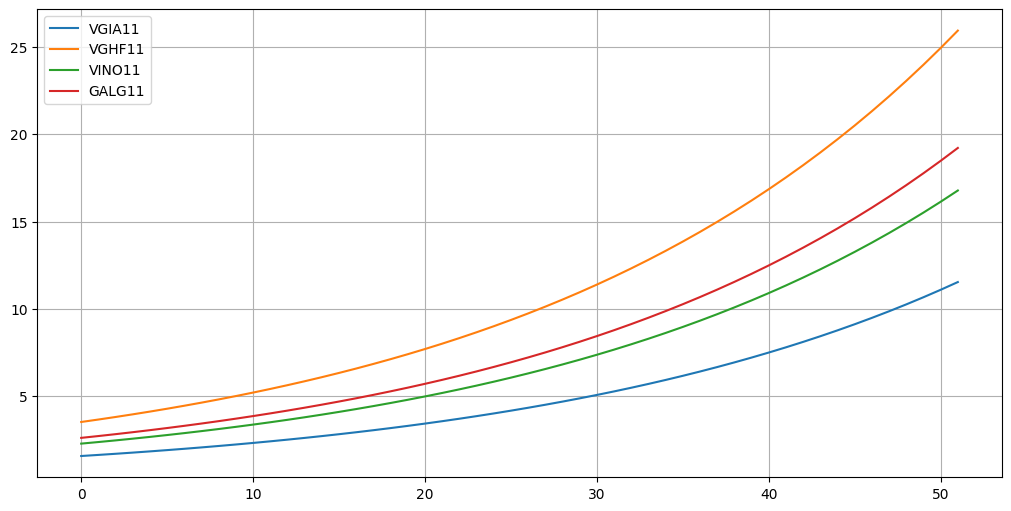

In [63]:
fig, ax = plt.subplots(figsize=(10,5), layout = "constrained")

ax.plot(resultados, label = tickers)

ax.legend(loc="upper left")
ax.grid(True)